# Feature Selection Using Scikit-Learn

### Import Packages

In [1]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

## Step 1: Build DataFrame and Define ML Problem


We will work with the "cell2celltrain" data set. This data set is already preprocessed, with the proper formatting, outliers and missing values taken care of, and all numerical columns scaled to the [0, 1] interval. One-hot encoding has been performed on all categorical columns. It is ready for modeling.

In [3]:
filename = os.path.join(os.getcwd(), "..", "..", "data", "cell2celltrain_cv.csv")
df = pd.read_csv(filename, header=0)

#### Define the Label

This is a binary classification problem in which we will predict customer churn. The label is the `Churn` column.

#### Identify Features

For now, our features will be all of the remaining columns in the dataset. After performing feature selection, we may choose to train our model on fewer features.

## Step 2. Create Labeled Examples from the Data Set 

In [4]:
y = df['Churn']
X = df.drop(columns = 'Churn', axis=1)
X.head()

print(type(X))

<class 'pandas.core.frame.DataFrame'>


## Step 3: Create Training and Test Data Sets
The code cell below creates training and test data sets. Since we will be performing model selection, we will split our 10% of our data to serve as a test set.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1234)

## Step 4: Perform Decision Tree Model Selection Using Grid Search


We will use scikit-learn's `GridSearchCV` to search over different combinations of possible hyperparameter values to find the set that results in the best cross-validation (CV) score. We will look for the best values of the following hyperparameters: the maximum depth of the tree (`max_depth`) and the minimum number of samples required to be at a leaf node (`min_samples_leaf`). 

### a. Set up the Parameter Grid

In [6]:
md = [2**n for n in range(2,6)]
msl = [25*2**n for n in range(0,3)]
param_grid={'max_depth':md, 'min_samples_leaf':msl}

param_grid

{'max_depth': [4, 8, 16, 32], 'min_samples_leaf': [25, 50, 100]}

### b. Perform Grid Search Cross-Validation


In [7]:
print('Running Grid Search...')

# 1. Create a DecisionTreeClassifier model object without supplying arguments
model = DecisionTreeClassifier()

# 2. Run a Grid Search with 5-fold cross-validation using our the model.
#   Pass all relevant parameters to GridSearchCV and assign the output to the object 'grid'
grid = GridSearchCV(model, param_grid, cv=5)

# 3. Fit the model to the training data and assign the fitted model to the 
#    variable grid_search
grid_search = grid.fit(X_train, y_train)

print('Done')

Running Grid Search...
Done


### c. Identify the Best Hyperparameter Values

In [8]:
best_md = grid_search.best_estimator_.max_depth
best_msl = grid_search.best_estimator_.min_samples_leaf

# Print best performing hyperparameter configuration
print('Best value for max depth: {0}'.format(best_md))
print('Best value for the minimum number of samples required to be at a leaf node: {0}'
      .format(best_msl))

# Print best accuracy score resulting from this configuration
print('Accuracy score: {0}'.format(grid_search.best_score_))

Best value for max depth: 4
Best value for the minimum number of samples required to be at a leaf node: 50
Accuracy score: 0.7147490424208727


## Step 5. Train the Best Model

In [9]:
# 1. Create a DecisionTreeClassifier model object and assign it to the variable 'model'
model = DecisionTreeClassifier(max_depth=4, min_samples_leaf=50)
    
# 2. Fit the model to the training data 
model.fit(X_train, y_train)

# 3. Use the predict() method to make predictions on the test data and assign the results to the variable
# 'class_label_predictions'
class_label_predictions = model.predict(X_test)

# 4. Compute the accuracy score and assign the result to the variable 'acc_score'
acc_score = accuracy_score(y_test, class_label_predictions)

print('Accuracy score: {0}'.format(acc_score))

Accuracy score: 0.7181194906953967


## Step 6: Perform  Feature Selection Using Scikit-learn

In [10]:
#1. Obtain "feature importance" scores from the model object and save the array to the variable 
# 'feature_imp'

feature_imp = model.feature_importances_

#2. Create a Pandas DataFrame with a list of all features and their scores. 
# Save the result to the variable 'df_features'

df_features = pd.DataFrame({'name': X_train.columns.values, 'imp': feature_imp})

#3. Sort df_features in descending order and
# save the result to the variable 'df_sorted'

df_sorted = df_features.sort_values(by='imp', ascending=False)

#4. Obtain the top 5 sorted feature names and save the result to list 'top_five' 

top_five = list(df_sorted.iloc[:5]['name'])

print('Top five features: {0}'.format(top_five))

Top five features: ['CurrentEquipmentDays', 'MonthsInService', 'MonthlyMinutes', 'PercChangeMinutes', 'HandsetRefurbished']


The code cell below produces a bar plot for the normalized importance of the top 5 most predictive features on which the examples were split for classification.

Text(0, 0.5, 'Normalized importance')

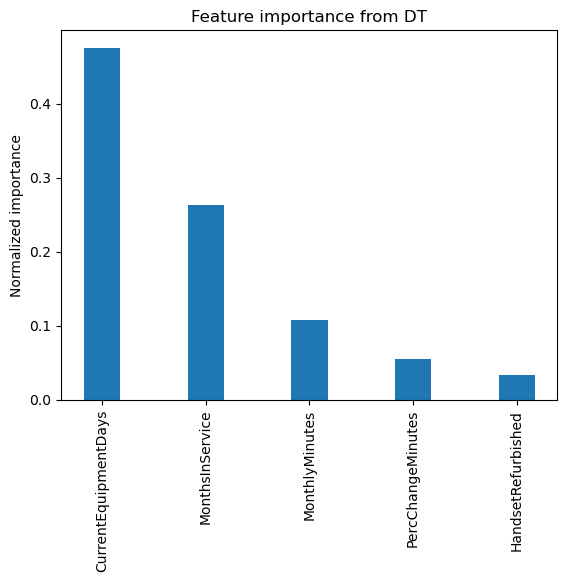

In [11]:
fig, ax = plt.subplots()
ax.bar(np.arange(5), sorted(model.feature_importances_, reverse=True)[:5], width = 0.35)
ax.set_xticks(np.arange(5))
ax.set_xticklabels(top_five, rotation = 90)
plt.title('Feature importance from DT')
ax.set_ylabel('Normalized importance')

We can train our model using only the most important features and see whether the resulting accuracy score will increase. We can also experiment with different combinations of features, such as removing the least important feature.